In [1]:
import json
import leaguepedia_parser
import requests
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
patch = requests.get(
    'https://raw.githubusercontent.com/CommunityDragon/Data/master/patches.json').json()["patches"][50]

champions = requests.get(
    f'http://ddragon.leagueoflegends.com/cdn/{patch["name"]}.1/data/en_US/championFull.json').json()["data"]

games = leaguepedia_parser.get_games(
    patch=leaguepedia_parser.compare.equal_to(patch["name"])
)

champions = {k.lower(): v for k, v in champions.items()}

In [3]:
win_rates = {}

for game in games:
    blue_winner = game["winner"] == "BLUE"
    for player in game["teams"]["BLUE"]["players"]:
        champ_name = player["championName"].replace("'", "").replace(" ", "").lower()
        rates = win_rates.get(champ_name)
        if not rates:
            rates = {
                "won": 0,
                "loss": 0,
            }

            win_rates[champ_name] = rates

        if blue_winner:
            rates["won"] += 1
        else:
            rates["loss"] += 1
    for player in game["teams"]["RED"]["players"]:
        champ_name = player["championName"].replace("'", "").replace(" ", "").lower()
        rates = win_rates.get(champ_name)
        if not rates:
            rates = {
                "won": 0,
                "loss": 0,
            }

            win_rates[champ_name] = rates

        if not blue_winner:
            rates["won"] += 1
        else:
            rates["loss"] += 1

In [17]:
import pandas as pd

expected = []
features = []

data = {}
data["win_rate"] = []
for key in list(champions.values())[0]["stats"]:
    data[key] = []

for champ_name in win_rates:
    champion = champions[champ_name]
    for field in champion["stats"]:
        data[field].append(champion["stats"][field])

    rates = win_rates[champ_name]
    data["win_rate"].append(rates["won"]/(rates["won"]+rates["loss"]))
    
df = pd.DataFrame(data, columns = list(data.keys()))
df = df.drop(["crit", "critperlevel"], axis=1)

In [18]:
df

,win_rate,hp,hpperlevel,mp,mpperlevel,movespeed,armor,armorperlevel,spellblock,spellblockperlevel,attackrange,hpregen,hpregenperlevel,mpregen,mpregenperlevel,attackdamage,attackdamageperlevel,attackspeedoffset,attackspeedperlevel
0,0.857143,535.72,79.0,200.00,0.0,335.0,24.300,3.75,30.0,0.00,550.0,5.590,0.65,50.00,0.00,50.544000,3.300000,-0.0947,3.40
1,0.450000,570.00,90.0,100.00,0.0,335.0,28.300,3.75,32.1,1.25,175.0,7.340,0.65,0.00,0.00,55.628000,3.350000,0.0000,2.00
2,0.588235,517.72,79.0,334.00,50.0,325.0,17.040,3.00,30.0,0.00,525.0,6.870,0.55,6.00,0.80,40.368000,2.600000,-0.0500,3.50
3,0.500000,586.52,89.0,312.40,55.0,335.0,24.544,3.30,30.0,0.00,425.0,6.505,0.60,8.59,0.65,52.048000,3.600000,-0.0300,2.90
4,0.510204,560.52,89.0,273.92,44.0,335.0,16.000,0.00,30.0,0.00,450.0,6.920,0.55,6.00,0.80,47.696000,2.200000,0.0000,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.500000,594.60,95.0,100.00,0.0,350.0,27.628,3.35,32.1,1.25,125.0,8.590,0.80,0.00,0.00,60.712000,3.400000,-0.0500,2.50
72,1.000000,572.80,85.0,327.20,40.0,350.0,24.040,3.00,32.1,1.25,125.0,7.510,0.75,7.59,0.50,55.208000,3.100000,-0.0650,2.70
73,1.000000,542.80,85.0,0.00,0.0,335.0,21.880,3.50,30.0,0.00,450.0,7.005,0.60,0.00,0.00,48.040000,3.000000,-0.0500,2.00
74,0.000000,507.68,76.0,325.60,45.0,340.0,21.880,3.50,30.0,0.00,525.0,5.420,0.55,6.00,0.80,54.937876,3.141593,0.0000,1.36


In [20]:
df.sum()

win_rate                   36.189901
hp                      41776.040000
hpperlevel               6351.000000
mp                      21324.920000
mpperlevel               2946.000000
movespeed               25480.000000
armor                    1788.048000
armorperlevel             258.850000
spellblock               2340.800000
spellblockperlevel         36.250000
attackrange             26450.000000
hpregen                   515.605000
hpregenperlevel            48.650000
mpregen                   647.710000
mpregenperlevel            44.550000
attackdamage             4119.847476
attackdamageperlevel      241.111593
attackspeedoffset          -1.969440
attackspeedperlevel       194.172000
dtype: float64

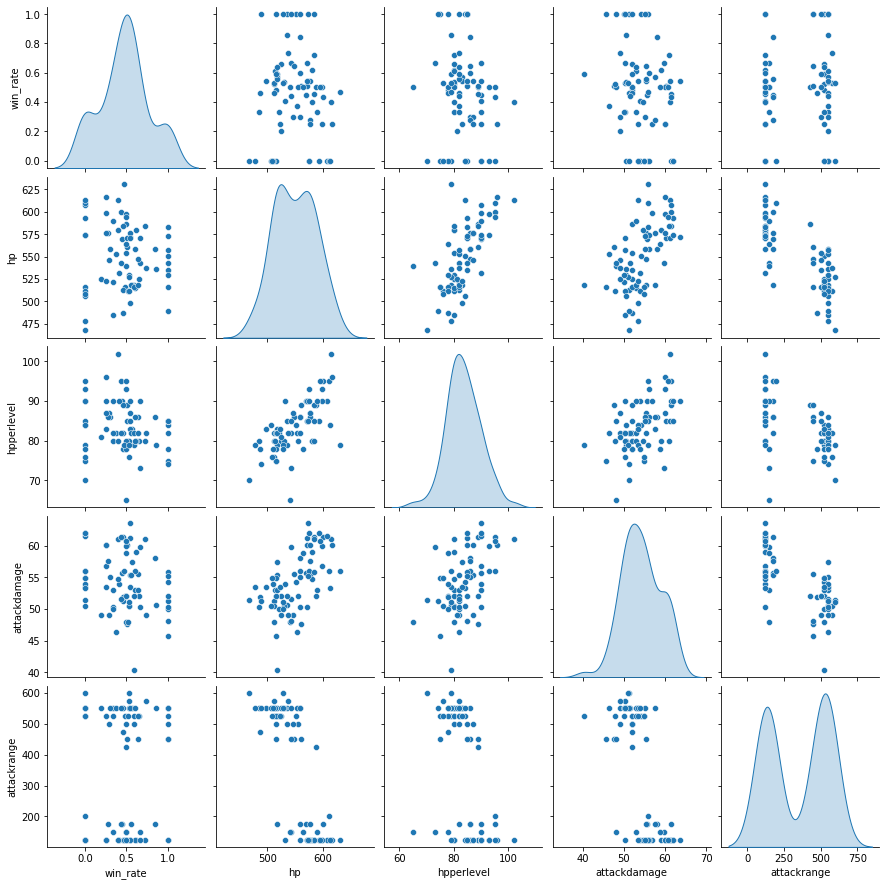

In [21]:
import seaborn as sns
sns.pairplot(df[['win_rate', 'hp', 'hpperlevel', 'attackdamage', 'attackrange']], diag_kind='kde')

In [26]:
expected = np.array(df["win_rate"])
features = np.array(df.drop("win_rate", axis=1))

print(expected.shape)
print(features.shape)

(76,)
(76, 18)


In [27]:
features[0]

array([ 5.3572e+02,  7.9000e+01,  2.0000e+02,  0.0000e+00,  3.3500e+02,
        2.4300e+01,  3.7500e+00,  3.0000e+01,  0.0000e+00,  5.5000e+02,
        5.5900e+00,  6.5000e-01,  5.0000e+01,  0.0000e+00,  5.0544e+01,
        3.3000e+00, -9.4700e-02,  3.4000e+00])

In [38]:
from tensorflow.keras.layers.experimental import preprocessing

print(features.shape[1])
normalize = preprocessing.Normalization(input_shape=(features.shape[1],))
normalize.adapt(features)

18


In [97]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def get_model():
    model = Sequential()
#     model.add(normalize)
    model.add(Dropout(0.2), input_shape())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    model.summary()
    return model

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', RandomForestRegressor(max_depth=2, random_state=0))
])

pipe.fit(features, expected)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=2, random_state=0))])

In [170]:
from xgboost import XGBRegressor 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

kfold = KFold(n_splits=10, random_state=7)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(oob_score=True,
                                        min_samples_leaf=60,
                                        max_features=None,
                                        max_depth=9))
])

param = {

}

gsearch = GridSearchCV(estimator=pipe, param_grid=param, return_train_score=True)
results = gsearch.fit(features, expected)
print(results.best_score_)
results

-0.2045429891355806


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        RandomForestRegressor(max_depth=9,
                                                              max_features=None,
                                                              min_samples_leaf=60,
                                                              oob_score=True))]),
             param_grid={}, return_train_score=True)

In [171]:
gsearch.score(features, expected)

-7.903431659572746e-05

In [172]:
gsearch.predict([[100000]*18])

array([0.47361095])